In [1]:
import os

%matplotlib inline
from IPython.display import Audio
from ipywidgets import interactive

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random, time, os
from sklearn.model_selection import train_test_split

from scipy.io import wavfile
import librosa
import tqdm
from tqdm import tqdm

sns.set()

SAMPLE_RATE = 16000       
T_MAX = 5
DT = 0.02

In [2]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr = None)




In [3]:
audio, fe = load_audio('datasets/g-sw/go/00b01445_nohash_0.wav')
Audio(audio ,rate = fe)

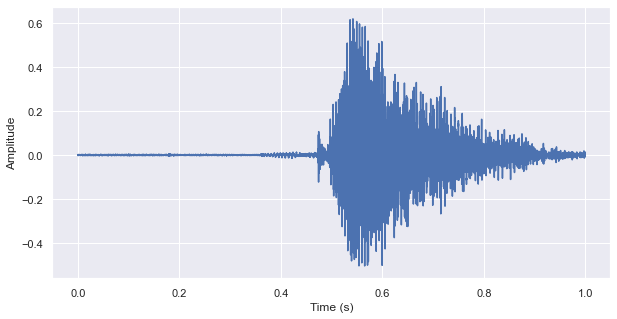

In [4]:
def plot_audio(audio_data, fe):
    # Intervalle de temps entre deux points.
    dt= 1/fe 
    # Variable de temps en seconde.
    t = dt*np.arange(len(audio_data)) 
    plt.plot(t, audio_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
## Insérez votre code ici

plt.figure(figsize = (10,5))
plot_audio(audio, fe)

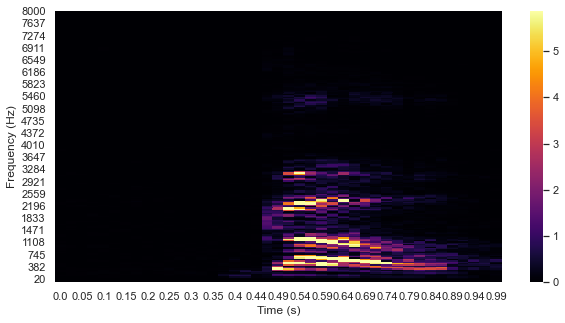

In [5]:
def spectrogram(audio, fe, dt):
    return np.abs(librosa.stft(audio, 
                        n_fft = int(dt*fe),
                       hop_length = int(dt*fe)
                       ))

def plot_spectrogram(audio, fe, dt=0.025):
    im = spectrogram(audio, fe, dt)
    sns.heatmap(np.rot90(im.T), cmap='inferno', vmin=0, vmax=np.max(im)/3)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    loc, labels = plt.yticks()
    l = np.array(loc[::-1]*fe/2/loc.max(), dtype=int)
    plt.yticks(loc, l)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    
plt.figure(figsize=(10, 5))
plot_spectrogram(audio,fe)    

/Users/malik.alymarecar/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


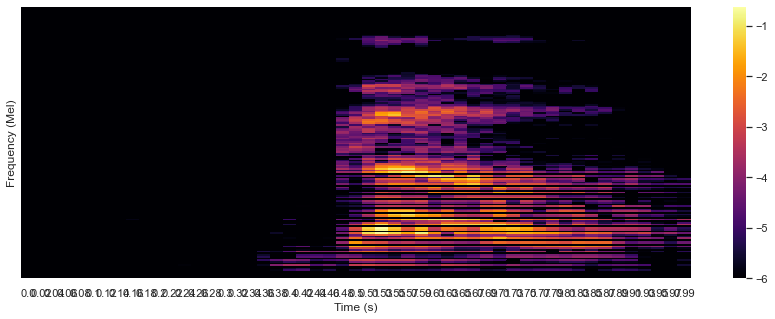

In [6]:
def logMelSpectrogram(audio, fe, dt):
    # Spectrogram
    stfts = np.abs(librosa.stft(audio,
                        n_fft = int(dt*fe),
                        hop_length = int(dt*fe),
                        center = True
                        )).T
    num_spectrogram_bins = stfts.shape[-1]
    # MEL filter
    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(dt*fe) + 1,
                                n_mels=num_spectrogram_bins,
                    ).T

    # Apply the filter to the spectrogram
    mel_spectrograms = np.tensordot(
                stfts,
                linear_to_mel_weight_matrix,
                1
            )
    return np.log(mel_spectrograms + 1e-6)

def plot_logMelSpectrogram(audio, fe, dt=0.025):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, fe, dt)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    
plt.figure(figsize=(15,5))
plot_logMelSpectrogram(audio, fe, 0.02)    

In [15]:
from glob import glob

# Single Google
list_filename = []
list_label = []
#
train_audio_path = 'datasets/g-sw'
train_labels = os.listdir(train_audio_path)
file = []
labels = []
for label in train_labels:
    if label != '_background_noise_':
        data_folder = train_audio_path + '/' + label
        files = glob(os.path.join(data_folder, '*'))
        for f in files:
            if f.endswith('wav'):
                file.append(f)
                labels.append(label)
train = pd.DataFrame({'file':file,'label':labels})

In [16]:
train

,file,label
0,datasets/g-sw/right/988e2f9a_nohash_0.wav,right
1,datasets/g-sw/right/1eddce1d_nohash_3.wav,right
2,datasets/g-sw/right/93ec8b84_nohash_0.wav,right
3,datasets/g-sw/right/6272b231_nohash_1.wav,right
4,datasets/g-sw/right/439c84f4_nohash_1.wav,right
...,...,...
64716,datasets/g-sw/four/93f30cc4_nohash_1.wav,four
64717,datasets/g-sw/four/0c40e715_nohash_0.wav,four
64718,datasets/g-sw/four/238c112c_nohash_0.wav,four
64719,datasets/g-sw/four/173ae793_nohash_1.wav,four


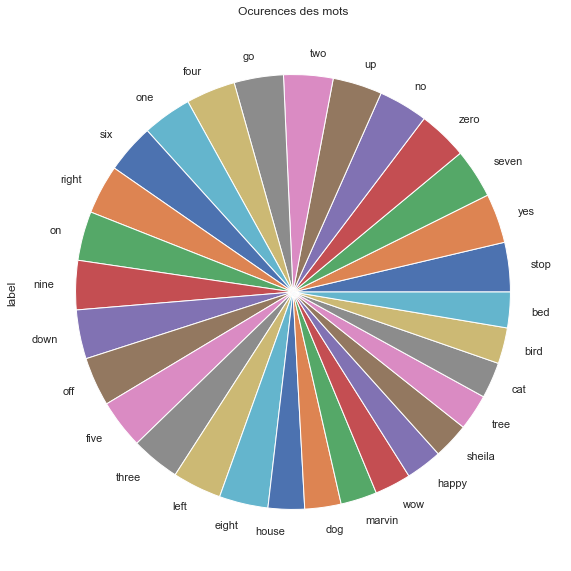

In [17]:
plt.figure(figsize=(10, 10))
plt.title("Ocurences des mots")
train['label'].value_counts(normalize = True).plot(kind = 'pie')

In [18]:
train['label'].value_counts()

stop      2380
yes       2377
seven     2377
zero      2376
no        2375
up        2375
two       2373
go        2372
four      2372
one       2370
six       2369
right     2367
on        2367
nine      2364
down      2359
off       2357
five      2357
three     2356
left      2353
eight     2352
house     1750
dog       1746
marvin    1746
wow       1745
happy     1742
sheila    1734
tree      1733
cat       1733
bird      1731
bed       1713
Name: label, dtype: int64

In [19]:
train['label'] = train['label'].replace(['right','five','zero','cat','yes','six','down','house','sheila','three','off','left','bed','happy','eight','bird', 'nine','tree','one', 'no','go','on','stop','seven','dog','four','wow','up','two','marvin'],
                                       list(range(30)))

words = {
    'right':    0,                                             
    'five':     1,
    'zero':     2,
    'cat':      3,
    'yes':      4,
    'six':      5,
    'down':     6,
    'house':    7,
    'sheila':   8,
    'three':    9,
    'off':     10,
    'left':    11,
    'bed':     12,
    'happy':   13,
    'eight':   14,
    'bird':    15,
    'nine':    16,
    'tree':    17,
    'one':     18,
    'no':      19,
    'go':      20,
    'on':      21,
    'stop':    22,
    'seven':   23,
    'dog':     24,
    'four':    25,
    'wow':     26,
    'up':      27,
    'two':     28,
    'marvin':  29
    
}

In [20]:
train

,file,label
0,datasets/g-sw/right/988e2f9a_nohash_0.wav,0
1,datasets/g-sw/right/1eddce1d_nohash_3.wav,0
2,datasets/g-sw/right/93ec8b84_nohash_0.wav,0
3,datasets/g-sw/right/6272b231_nohash_1.wav,0
4,datasets/g-sw/right/439c84f4_nohash_1.wav,0
...,...,...
64716,datasets/g-sw/four/93f30cc4_nohash_1.wav,25
64717,datasets/g-sw/four/0c40e715_nohash_0.wav,25
64718,datasets/g-sw/four/238c112c_nohash_0.wav,25
64719,datasets/g-sw/four/173ae793_nohash_1.wav,25


In [21]:
X_train_path, X_test_path, Y_train, Y_test = train_test_split(train.file, train["label"], test_size=0.2, random_state=1234, stratify=train["label"])

In [24]:
# Mise au format array()
Y_train = Y_train.values # array([ 3, 19,  1, ...,  6, 16, 27])
Y_test = Y_test.values

In [28]:
def load_data(audio_path, dt=0.02, T_max=2):
    X_audio=[]
    size_ =len(audio_path)
    with tqdm(total=size_) as pbar:
        for i, a_path in enumerate(audio_path) :
            pbar.update(1)
            # Load the audio file
            data, fe = load_audio(a_path)

            # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
            if len(data)>= T_max*fe:
                data = data[:int(T_max*fe)]

            # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
            else :
                data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])

            # Apply the logMelSpectrogram function.    
            spectre_audio = logMelSpectrogram(data, fe, dt)
            X_audio.append(spectre_audio)
        return np.array(X_audio)


In [29]:
X_train = load_data(X_train_path)

100%|██████████| 51776/51776 [03:10<00:00, 271.86it/s]


In [62]:
X_train.shape[1:] # (101, 161)

(101, 161)

In [30]:
X_test = load_data(X_test_path)

100%|██████████| 12945/12945 [00:39<00:00, 329.94it/s]


In [63]:
X_test.shape[1:] # (101, 161)

(101, 161)

# Modélisation

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, LeakyReLU, Flatten, GlobalAveragePooling1D
from keras.optimizers import Adam

num_classes = 30

model = Sequential()
# Part 1
model.add(Conv1D(64, kernel_size=5, dilation_rate=2, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LeakyReLU())
# Part 2
model.add(Conv1D(128, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
# Part 3
model.add(Conv1D(256, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())
# Classification part
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 93, 64)            51584     
_________________________________________________________________
dropout (Dropout)            (None, 93, 64)            0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 93, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 85, 128)           41088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 128)           0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 85, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 77, 256)           1

# Entraînement

In [32]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=32, epochs=50)

Epoch 1/50
1618/1618 [==============================] - 53s 33ms/step - loss: 2.5879 - accuracy: 0.2586 - val_loss: 1.1918 - val_accuracy: 0.6433
Epoch 2/50
1618/1618 [==============================] - 46s 28ms/step - loss: 1.0681 - accuracy: 0.6803 - val_loss: 0.7135 - val_accuracy: 0.7812
Epoch 3/50
1618/1618 [==============================] - 49s 30ms/step - loss: 0.8593 - accuracy: 0.7466 - val_loss: 0.5884 - val_accuracy: 0.8232
Epoch 4/50
1618/1618 [==============================] - 50s 31ms/step - loss: 0.7569 - accuracy: 0.7796 - val_loss: 0.5879 - val_accuracy: 0.8233
Epoch 5/50
1618/1618 [==============================] - 50s 31ms/step - loss: 0.6974 - accuracy: 0.7977 - val_loss: 0.4919 - val_accuracy: 0.8565
Epoch 6/50
1618/1618 [==============================] - 49s 31ms/step - loss: 0.6675 - accuracy: 0.8075 - val_loss: 0.5363 - val_accuracy: 0.8450
Epoch 7/50
1618/1618 [==============================] - 48s 30ms/step - loss: 0.6321 - accuracy: 0.8192 - val_loss: 0.4498 -

# Sauvegarde des fichiers

In [36]:
model.save('model/g-sw/g_singleword.h5')

In [37]:
model.save_weights('model/g-sw/g_singleword_weights')

# Evaluation

In [38]:
from sklearn.metrics import classification_report
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)


print(classification_report(Y_test, test_pred_class))

#test_pred

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       473
           1       0.96      0.93      0.94       471
           2       1.00      0.93      0.97       475
           3       0.95      0.96      0.96       347
           4       1.00      0.93      0.96       476
           5       0.99      0.92      0.95       474
           6       0.75      0.97      0.84       472
           7       0.97      0.96      0.97       350
           8       0.96      0.97      0.97       347
           9       0.92      0.92      0.92       471
          10       0.91      0.89      0.90       471
          11       0.92      0.96      0.94       471
          12       0.68      0.96      0.80       343
          13       0.98      0.98      0.98       348
          14       0.96      0.94      0.95       470
          15       0.97      0.92      0.94       346
          16       0.97      0.90      0.93       473
          17       0.94    

In [39]:
from sklearn.metrics import confusion_matrix

pd.crosstab(Y_test, test_pred_class, rownames = ['Classes Réelles'], colnames = ['Classes prédites'])

Classes prédites,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Classes Réelles,,,,,,,,,,,,,,,,,,,,,
0,440,6,0,0,0,0,0,0,0,3,...,0,4,0,2,0,0,0,1,0,0
1,3,437,0,0,0,0,0,0,0,0,...,0,14,0,2,1,0,0,1,0,0
2,0,0,443,1,0,0,2,0,10,0,...,2,1,0,10,0,0,0,0,2,0
3,0,0,0,334,0,0,2,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,2,443,0,3,0,0,0,...,1,0,0,2,0,1,0,1,0,0
5,0,0,0,2,0,435,0,0,0,1,...,0,2,0,19,0,1,0,2,0,0
6,0,0,0,0,0,0,456,0,0,0,...,3,2,1,2,1,0,0,0,1,0
7,1,1,0,0,0,0,0,336,0,0,...,1,0,0,2,0,0,0,3,0,0
8,0,1,0,0,0,0,2,0,336,1,...,0,0,0,2,0,1,0,0,0,0


# Prédiction

In [41]:
dataT, feT = load_audio('datasets/g-sw/marvin/a879a2c3_nohash_0.wav')
dt=0.02
T_max=2
            
        # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
if len(dataT)>= T_max*feT:
    dataT = dataT[:int(T_max*feT)]
        
        # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
else :
    dataT = np.concatenate([dataT, np.zeros(int(T_max*feT - len(dataT)))])
            
        # Apply the logMelSpectrogram function.    
spectre_audio = logMelSpectrogram(dataT, feT, dt)

/Users/malik.alymarecar/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [42]:
Audio(dataT, rate = feT)

In [45]:
spectre_audio = spectre_audio.reshape(1,101,161)

In [59]:
def displaylabel(prediction):
    listOfKeys = [key  for (key, value) in words.items() if value == prediction]
    return listOfKeys[0]

In [60]:
prediction = model.predict(spectre_audio).argmax()
displaylabel(prediction)

'marvin'